In [1]:
#%% Importamos las librerias
from shu_dataset import RegistersShuDataset
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from random import sample, shuffle
from copy import deepcopy
import scipy.io as sio
from mne.decoding import CSP

import matplotlib.pyplot as plt 
import seaborn as sns

In [2]:
#%% Leemos los datos y adaptamos la base de datos para obtener las epocas acondicionadas
path_root = "/home/bruno/Academico/Doctorado/Neuro_Fairness/Shu_Dataset/"
dataset_field="000_Dataset_Preprocessing/"
dataset_path_root = path_root + dataset_field
save_figures = True
figures_path_root = path_root + "Processing_Figures/"
participants=["sub-001","sub-002","sub-003","sub-004","sub-005",
              "sub-006","sub-007","sub-008","sub-009","sub-010",
              "sub-011","sub-012","sub-013","sub-014","sub-015",
              "sub-016","sub-017","sub-018","sub-019","sub-020",
              "sub-021","sub-022","sub-023","sub-024","sub-025"]

sessions=["ses-01","ses-02","ses-03","ses-04","ses-05"]

In [3]:
dataset={}
for participant in participants:
    flag_participant=True
    dataset[participant]={}
    for session in sessions: 
        database_path= dataset_path_root + participant +"/"
        data_path=participant+"_"+session+"_task_motorimagery_eeg_preprocessing.mat"
        data=sio.loadmat(database_path + data_path)

        dataset[participant][session]= {}
        dataset[participant][session]['data'] = data['data']
        dataset[participant][session]['labels_trials'] = np.squeeze(data['labels_trials'])
        dataset[participant][session]['n_epochs'] = data['data'].shape[0]
        dataset[participant][session]['n_samples'] = data['data'].shape[2]
        dataset[participant][session]['n_chans'] = data['data'].shape[1]

        if flag_participant and session == sessions[-1]:
            dataset[participant]['group_medidator'] = data['group_medidator']
            dataset[participant]['gender'] = data['gender']
            dataset[participant]['id_participant'] = data['id_participant']
            dataset[participant]['sfreq'] = data['sfreq']
            ch_names = data['ch_names']
            it=0
            for ch in data['ch_names']:
                if ' ' in ch:
                    ch_names[it]=ch[:-1]
                it+=1
            dataset[participant]['ch_names']=ch_names 
            dataset[participant]['age'] = data['age']
            flag_participant = False

In [4]:
dataset[participant].keys()

dict_keys(['ses-01', 'ses-02', 'ses-03', 'ses-04', 'ses-05', 'group_medidator', 'gender', 'id_participant', 'sfreq', 'ch_names', 'age'])

In [5]:
# Concatenamos las sesiones de los sujetos
nchan = dataset[participant][session]['n_chans']
nsamples = dataset[participant][session]['n_samples']

for participant in participants:
    data_=np.zeros((1,nchan,nsamples))
    labels_=np.zeros((1))
    for session in sessions: 
        data_ = np.concatenate((data_, dataset[participant][session]['data']),axis=0)
        labels_ = np.concatenate((labels_, dataset[participant][session]['labels_trials']),axis=0)
    data_ = data_[1:,:,:]
    labels_ = labels_[1:]
    
    dataset[participant]['data_sessions'] = data_.copy()
    dataset[participant]['labels_sessions'] = labels_.copy()
    dataset[participant]['data_gender'] =  np.array(list(dataset[participant]['gender']) * data_.shape[0])
    dataset[participant]['group_participant'] =  np.array(list([participant]) * data_.shape[0])

In [6]:
index_female = []
index_male = []
for participant in participants:
    if dataset[participant]['gender'] == 'M':
        index_male.append(participant)
    elif dataset[participant]['gender'] == 'F':
        index_female.append(participant)
print(f"Participantes hombres: {index_male}")
print(f"Participantes mujeres: {index_female}")

Participantes hombres: ['sub-001', 'sub-002', 'sub-008', 'sub-012', 'sub-013', 'sub-015', 'sub-017', 'sub-018', 'sub-019', 'sub-021', 'sub-022', 'sub-023', 'sub-025']
Participantes mujeres: ['sub-003', 'sub-004', 'sub-005', 'sub-006', 'sub-007', 'sub-009', 'sub-010', 'sub-011', 'sub-014', 'sub-016', 'sub-020', 'sub-024']


In [11]:
idx_male_test = sample(idx_male, n_test_participant)
idx_female_test = sample(idx_female, n_test_participant)
idx_female_test

['sub-006', 'sub-011', 'sub-014', 'sub-004']

In [12]:
n_features = 6
N_it = 1
n_test_participant = 4

info_exp = {}
info_clfs = {}
for it in range(N_it):
    dic_aux = {}
    
    X_train = None
    labels_train = None
    
    idx_male = index_male.copy()
    idx_female = index_female.copy()
    
    # DIVIDE DATASET IN TRAIN, TEST AND VAL
    # TEST PARTICIPANTS:
    idx_male_test = sample(idx_male, n_test_participant)
    idx_female_test = sample(idx_female, n_test_participant)
    for it_ in range(n_test_participant):
        idx_male.remove(idx_male_test[it_])
        idx_female.remove(idx_female_test[it_])
    idx_test = idx_male_test + idx_female_test
    dic_aux['reg_idx_test'] = idx_test   
    
    idx_male_train = idx_male.copy()
    idx_female_train = idx_female.copy()
    idx_train = idx_male_train + idx_female_train
    dic_aux['reg_idx_train'] = idx_train


    # CONCATENAMOS EL CONJUNTO DE DATOS
    # TRAIN 
    X_train = np.zeros((1,nchan,nsamples))
    labels_train = np.zeros(1)
    for participant in idx_train:
        X_train = np.concatenate((X_train, dataset[participant]['data_sessions']),axis=0)
        labels_train = np.concatenate((labels_train, dataset[participant]['labels_sessions']),axis=0)
    X_train = X_train[1:,:]
    labels_train = labels_train[1:]
    
    #--------------------------  CSP TRANSFORM -------------------------------#
    csp = CSP(n_components = n_features, reg='oas', norm_trace = True)
    csp.fit(X_train, labels_train)

    # #--------------------  Kullback Lleiber Divergence  ----------------------#
    # data_csp = {}
    # matrix_mean_csp = np.zeros((6,len(participants)))
    # matrix_cova_csp = np.zeros((6,6,len(participants)))
    
    # for participant in participants:
    #     data_csp[participant] = csp.transform(dataset[participant]['data_sessions'])



Computing rank from data with rank=None


: 

: 

In [9]:
X_train.shape

(6185, 32, 1000)

--------------------------------------------------------------------------------------------------------

# Eliminar el sujeto cuya media se aleje mas de la media general en hombres

In [66]:
means_male_csp = matrix_mean_csp[:,index_h].copy()
mean_male = means_male_csp.mean(axis=1,keepdims=True)

dist_males_mean = np.linalg.norm(means_male_csp - mean_male,axis = 0)
idx_male_exclude = dist_males_mean.argmax()
print(index_h)
print(f'El sujeto que es excluido del análisis por tener una distancia con respecto a la media es {dataset_df.iloc[index_h[idx_male_exclude],-1]}')
index_h.remove(idx_male_exclude)
print(index_h)

[0, 1, 7, 11, 12, 14, 16, 17, 18, 20, 21, 22, 24]
El sujeto que es excluido del análisis por tener una distancia con respecto a la media es sub-002
[0, 7, 11, 12, 14, 16, 17, 18, 20, 21, 22, 24]


# Calculamos la divergencia de Kullback-Llieber 

Esta medida la realizamos para cada sujeto respecto a los demás

In [67]:
# Definimos la función que calcula la Divergencia de Kullback-Lleiber simetrizada
def Symmetrised_Divergence_KL(mu_p,mu_q,sigma_p,sigma_q):
    k=len(mu_p)
    
    inv_sigma_p=np.linalg.inv(sigma_p)
    inv_sigma_q=np.linalg.inv(sigma_q)
    
    term0_a=(mu_p - mu_q).T
    term0_b=inv_sigma_p + inv_sigma_q
    term0_c=mu_p - mu_q
    term1 = term0_a @ term0_b @ term0_c
    
    term2= np.trace( inv_sigma_q @ sigma_p )
    
    term3=np.trace( inv_sigma_p @ sigma_q )
    
    D_skl =(term1 + term2+ term3  - 2*k)/4
    
    return D_skl

# Estimamos las distancias para los pares de sujetos H-M 

In [68]:
D_KLS=np.zeros((len(participants),len(participants)))
for it0 in range(0,len(participants)-1):
    for it1 in range(it0+1,len(participants)):
        mu_p = matrix_mean_csp[:,it0]
        mu_q = matrix_mean_csp[:,it1]
        sigma_p = matrix_cov_csp[:,:,it0]
        sigma_q = matrix_cov_csp[:,:,it1]
        D_KLS[it0,it1]=Symmetrised_Divergence_KL(mu_p,mu_q,sigma_p,sigma_q)
print(D_KLS)

[[ 0.          2.39277484  7.6503812   4.51685014  6.57681153  6.29301747
   7.60672722  9.03659531  7.9366608   4.01379969  4.2160063   8.66207099
   6.7111792   4.02005317  6.83293882  6.86203546  5.79319541  4.953428
   5.97093242  5.81754647  4.60158903  7.24312149 10.79105896  5.71520601
   5.7852569 ]
 [ 0.          0.         14.69312308  2.63253556  4.34346272  3.97981936
   5.79085628  5.54940056  6.04426416  3.70730618  2.64648824  5.45372226
   7.60237387  5.41163217  4.21810289  6.51602915  8.79332116  6.66874427
   5.71970359  5.70998889  6.21314256  5.72784582  7.73982638  6.44844323
   5.13165036]
 [ 0.          0.          0.         13.62166084 10.79295578 13.54623889
   9.97346269 22.0008359  16.48689502  5.35818024  8.77993194  7.64425653
   4.16074342  9.53712787  9.56573351  8.45304379  7.05664723  2.97573789
   9.11280319 10.03799511  3.42402055 16.07332108 12.63623806  2.94918271
   5.93999874]
 [ 0.          0.          0.          0.          5.49834279  4.6475

In [72]:
from random import sample, shuffle

In [83]:
# Estimamos la divergencia de Kullback-Lleiber
D_KLS_HM = []
for idx_h in index_h:
    for idx_m in index_m:
        if D_KLS[idx_h,idx_m]!=0:
            D_KLS_HM.append(D_KLS[idx_h,idx_m])
            
for idx_m in index_m:
    for idx_h in index_h:
        if D_KLS[idx_m,idx_h]!=0:
            D_KLS_HM.append(D_KLS[idx_m,idx_h])
D_KLS_HM =  sample(D_KLS_HM, 66)
D_KLS_HM=np.array(D_KLS_HM)
D_KLS_HM_=np.array(D_KLS_HM_)

In [84]:
D_KLS_HH = []
for idx_h0 in index_h:
    for idx_h1 in index_h:
        if D_KLS[idx_h0,idx_h1]!=0:
            D_KLS_HH.append(D_KLS[idx_h0,idx_h1])
D_KLS_HH=np.array(D_KLS_HH)


In [85]:
D_KLS_MM = []
for idx_m0 in index_m:
    for idx_m1 in index_m:
        if D_KLS[idx_m0,idx_m1]!=0:
            D_KLS_MM.append(D_KLS[idx_m0,idx_m1])
D_KLS_MM=np.array(D_KLS_MM)

# Realizamos un histograma de las tres medidas

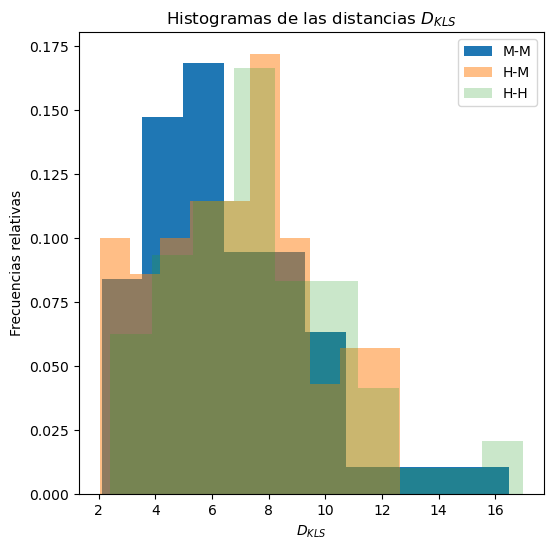

In [86]:
fig,ax=plt.subplots()
fig.set_size_inches((6,6))
ax.hist(D_KLS_MM,label='M-M',density=True,alpha=1)
ax.hist(D_KLS_HM,label='H-M',density=True,alpha=0.5)
ax.hist(D_KLS_HH,label='H-H',density=True,alpha=0.25)

ax.set_xlabel('$D_{KLS}$')
ax.set_ylabel('Frecuencias relativas')
ax.set(title='Histogramas de las distancias $D_{KLS}$')

ax.legend()

# Prueba de Normalidad

In [87]:
# 
from scipy.stats import ks_1samp
from scipy.stats import ttest_1samp
from scipy.stats import wilcoxon
from scipy import stats

In [88]:
alpha = 0.05
alpha_bonferroni = alpha / 3

test_norm = pd.DataFrame(columns=['statistics','p-value','H0'])
comparations = ['M-F','F-F','M-M']

norm_test = ks_1samp(D_KLS_HM,stats.norm.cdf)
if norm_test.pvalue <= alpha_bonferroni:
    test_norm.loc['M-F']=[norm_test.statistic,norm_test.pvalue,False]
else:
    test_norm.loc['M-F']=[norm_test.statistic,norm_test.pvalue,True]


norm_test = ks_1samp(D_KLS_MM,stats.norm.cdf)
if norm_test.pvalue <= alpha_bonferroni:
    test_norm.loc['F-F']=[norm_test.statistic,norm_test.pvalue,False]
else:
    test_norm.loc['F-F']=[norm_test.statistic,norm_test.pvalue,True]


norm_test = ks_1samp(D_KLS_MM,stats.norm.cdf)
if norm_test.pvalue <= alpha_bonferroni:
    test_norm.loc['M-M']=[norm_test.statistic,norm_test.pvalue,False]
else:
    test_norm.loc['M-M']=[norm_test.statistic,norm_test.pvalue,True]

print(f'Significancia: {alpha_bonferroni:.2}')
print(f'Intervalo de confianza: {100*(1-alpha_bonferroni)}')
test_norm

Significancia: 0.017
Intervalo de confianza: 98.33333333333333


,statistics,p-value,H0
M-F,0.982106,9.548257e-116,False
F-F,0.982254,5.524530e-116,False
M-M,0.982254,5.524530e-116,False


# Realizamos un test de Mann Whitney - U


In [89]:
import scipy.stats as st

In [90]:
test = pd.DataFrame(columns=['statics','p-value','H0'])
U_test = st.mannwhitneyu(D_KLS_HM,D_KLS_HH)
if U_test.pvalue <= alpha:
    test.loc['MF - MM']=[U_test.statistic,U_test.pvalue,False]
else: 
    test.loc['MF - MM']=[U_test.statistic,U_test.pvalue,True]

U_test = st.mannwhitneyu(D_KLS_HM,D_KLS_MM)
if U_test.pvalue <= alpha:
    test.loc['MF - FF']=[U_test.statistic,U_test.pvalue,False]
else: 
    test.loc['MF - FF']=[U_test.statistic,U_test.pvalue,True]
    
test

,statics,p-value,H0
MF - MM,1864.0,0.153642,True
MF - FF,2391.0,0.333485,True


In [37]:
def t_test(data0,data1):
    n0=data0.shape[0]
    n1=data1.shape[0]
    mu0=data0.mean()
    mu1=data1.mean()
    var0=np.var(data0)
    var1=np.var(data1)

    t = (mu0-mu1)/np.sqrt(var0/n0 + var1/n1)

    #Estimamos los grados de libertad desbalanceados 

    v =  (var0/n0 + var1/n1) **2 / ( ((var0/n0)**2  / (n0-1)) +  ((var1/n1)**2  / (n1-1)))

    #Distribución t-student
    t_student = st.t(df=v)

    #p-value
    p_value = 2*t_student.cdf(-np.abs(t))
    return t,p_value

Hipotesis Nula: no hay diferencias entre las medias: $μ_{x}=μ_{y}$

In [44]:
table = {}
table['HM - HH'] = {}
table['HM - HH']['t-test'] , table['HM - HH']['p-value'] = t_test(D_KLS_HM,D_KLS_HH)
table['HM - MM'] = {}
table['HM - MM']['t-test'] , table['HM - MM']['p-value'] = t_test(D_KLS_HM,D_KLS_MM)
table['HH - MM'] = {}
table['HH - MM']['t-test'] , table['HH - MM']['p-value'] = t_test(D_KLS_HH,D_KLS_MM)

t_test_table=pd.DataFrame(table).transpose()
t_test_table

,t-test,p-value
HM - HH,-1.465300,0.144801
HM - MM,0.734814,0.463721
HH - MM,1.923889,0.056390


---------------------------------------------------------------------------------------

# Dividimos los datos por el tipo de imagenería motora

In [ ]:
labels = np.unique(DATA['sub-001']['labels_trials'])

for participant in participants:
    data = DATA[participant]['data_csp']
    DATA[participant]['data_csp_class1']=data[:,DATA[participant]['labels_trials'] == labels[0]]
    DATA[participant]['data_csp_class2']=data[:,DATA[participant]['labels_trials'] == labels[1]]
    
    DATA[participant]['mu_csp_class1']=data[:,DATA[participant]['labels_trials'] == labels[0]].mean(axis=1) 
    DATA[participant]['mu_csp_class2']=data[:,DATA[participant]['labels_trials'] == labels[1]].mean(axis=1) # Se puede quitar el keepdims
    DATA[participant]['sigma_csp_class1']=np.cov(data[:,DATA[participant]['labels_trials'] == labels[0]])
    DATA[participant]['sigma_csp_class2']=np.cov(data[:,DATA[participant]['labels_trials'] == labels[1]])
    
DATA_TABLE = pd.DataFrame(DATA).transpose()
DATA_TABLE.reset_index(inplace=True)
DATA_TABLE.rename(columns = {'index':'subject'},inplace = True)
DATA_TABLE

# Graficamos


In [ ]:
# Aplicamos PCA
data_csp_pca_class1=[]
mu_csp_pca_class1=[]
sigma_csp_pca_class1=[]
eig_val_pca_class1=[]
data_csp_pca_class2=[]
mu_csp_pca_class2=[]
sigma_csp_pca_class2=[]
eig_val_pca_class2=[]
for it in range(len(DATA_TABLE)):
    X = DATA_TABLE.iloc[it]['data_csp_class1']
    pca_=pca()
    eig_val , _= pca_.Fit(X = X)
    X_proj = pca_.Project(X,n=2,plot=False)
    data_csp_pca_class1.append(X_proj)
    eig_val_pca_class1.append(eig_val)
    mu_csp_pca_class1.append(data_csp_pca_class1[-1].mean(axis=1))
    sigma_csp_pca_class1.append(np.cov(data_csp_pca_class1[-1]))
    
    X = DATA_TABLE.iloc[it]['data_csp_class2']
    pca_=pca()
    eig_val , _= pca_.Fit(X = X)
    X_proj = pca_.Project(X,n=2,plot=False)
    data_csp_pca_class2.append(X_proj)
    eig_val_pca_class2.append(eig_val)
    mu_csp_pca_class2.append(data_csp_pca_class2[-1].mean(axis=1))
    sigma_csp_pca_class2.append(np.cov(data_csp_pca_class2[-1]))
    
# Vemos los eigenvalues
fig,ax = plt.subplots()
a=1
for it in range(len(DATA_TABLE)):  
    x=np.linspace(0,len(eig_val_pca_class1[it]),len(eig_val_pca_class1[it]))
    ax.bar(x,eig_val_pca_class1[it],alpha=a)
    a-=0.005

fig,ax = plt.subplots()
a=1
for it in range(len(DATA_TABLE)):  
    x=np.linspace(0,len(eig_val_pca_class2[it]),len(eig_val_pca_class2[it]))
    ax.bar(x,eig_val_pca_class2[it],alpha=a)
    a-=0.005



In [ ]:
#Graficamos los datos de hombre
fig , ax = plt.subplots()
fig.set_size_inches((12,12))

n_std=3.
#len(DATA_TABLE)
for it in index_h[1:3]:
    ax.scatter(data_csp_pca_class1[it][0,:],data_csp_pca_class1[it][1,:],
                   marker='o',cmap='tab20b',color="C{}".format(it),facecolors='none',
                   alpha=0.25)
    ax.scatter(data_csp_pca_class2[it][0,:],data_csp_pca_class2[it][1,:],
                   marker='s',cmap='tab20b',color="C{}".format(it),facecolors='none',
                   alpha=0.25)
for it in index_h[1:3]:
    ax.scatter(mu_csp_pca_class1[it][0],mu_csp_pca_class1[it][1],marker='o',cmap='tab20b',color="C{}".format(it),label=f"H{it} class 1")
    ax = Plot_Ellipse_Distribution(mu_csp_pca_class1[it], sigma_csp_pca_class1[it], nstd =1., ax=ax,color="C{}".format(it))
    ax.scatter(mu_csp_pca_class2[it][0],mu_csp_pca_class2[it][1],marker='o',cmap='tab20b',color="C{}".format(it),label=f"H{it} class 2")
    ax = Plot_Ellipse_Distribution(mu_csp_pca_class2[it], sigma_csp_pca_class2[it], nstd =1., ax=ax,color="C{}".format(it))
    
ax.set_xlabel('X1 pca')
ax.set_ylabel('X2 pca')
ax.set_title('PCA para hombres ')
ax.legend()
ax.set_aspect('equal', adjustable='datalim')

In [ ]:
#Graficamos los datos de mujeres
fig , ax = plt.subplots()
fig.set_size_inches((12,12))

n_std=3.
#len(DATA_TABLE)
for it in index_m[1:3]:
    ax.scatter(data_csp_pca_class1[it][0,:],data_csp_pca_class1[it][1,:],
                   marker='^',cmap='tab20b',color="C{}".format(it),facecolors='none',
                   alpha=0.25)
    ax.scatter(data_csp_pca_class2[it][0,:],data_csp_pca_class2[it][1,:],
                   marker='P',cmap='tab20b',color="C{}".format(it),facecolors='none',
                   alpha=0.25)
for it in index_m[1:3]:
    ax.scatter(mu_csp_pca_class1[it][0],mu_csp_pca_class1[it][1],marker='^',cmap='tab20b',color="C{}".format(it),label=f"M{it} class 1")
    ax = Plot_Ellipse_Distribution(mu_csp_pca_class1[it], sigma_csp_pca_class1[it], nstd =1., ax=ax,color="C{}".format(it))
    ax.scatter(mu_csp_pca_class2[it][0],mu_csp_pca_class2[it][1],marker='P',cmap='tab20b',color="C{}".format(it),label=f"M{it} class 2")
    ax = Plot_Ellipse_Distribution(mu_csp_pca_class2[it], sigma_csp_pca_class2[it], nstd =1., ax=ax,color="C{}".format(it))
    
ax.set_xlabel('X1 pca')
ax.set_ylabel('X2 pca')
ax.set_title('PCA para mujeres ')
ax.legend()
ax.set_aspect('equal', adjustable='datalim')

In [ ]:
fig , ax = plt.subplots()
fig.set_size_inches((6,6))

n_std=3.
#len(DATA_TABLE)
it=0
for it_m, it_h in (index_m[1:3], index_h[1:3]):
    ax.scatter(data_csp_pca_class1[it_m][0,:],data_csp_pca_class1[it_m][1,:],
                   marker='^',cmap='tab20b',color="C{}".format(it),facecolors='none',
                   alpha=0.25)
    
    ax.scatter(data_csp_pca_class1[it_h][0,:],data_csp_pca_class1[it_h][1,:],
                   marker='o',cmap='tab20b',color="C{}".format(it+1),facecolors='none',
                   alpha=0.25)
    
    ax.scatter(data_csp_pca_class2[it_m][0,:],data_csp_pca_class2[it_m][1,:],
                   marker='P',cmap='tab20b',color="C{}".format(it),facecolors='none',
                   alpha=0.25)
    
    ax.scatter(data_csp_pca_class2[it_h][0,:],data_csp_pca_class2[it_h][1,:],
                   marker='s',cmap='tab20b',color="C{}".format(it+1),facecolors='none',
                   alpha=0.25)
    it+=2

it=0
for it_m, it_h in (index_m[1:3], index_h[1:3]):
    ax.scatter(mu_csp_pca_class1[it_m][0],mu_csp_pca_class1[it_m][1],
               marker='^',cmap='tab20b',color="C{}".format(it),
               label=f"M{it_m} clase 1")
    ax = Plot_Ellipse_Distribution(mu_csp_pca_class1[it_m], sigma_csp_pca_class1[it_m], nstd =1., ax=ax,color="C{}".format(it))
    ax.scatter(mu_csp_pca_class2[it_m][0],mu_csp_pca_class2[it_m][1],
               marker='P',cmap='tab20b',color="C{}".format(it),
               label=f"M{it_m} clase 2")
    ax = Plot_Ellipse_Distribution(mu_csp_pca_class2[it_m], sigma_csp_pca_class2[it_m], nstd =1., ax=ax,color="C{}".format(it))
    
    ax.scatter(mu_csp_pca_class1[it_h][0],mu_csp_pca_class1[it_h][1],
               marker='o',cmap='tab20b',color="C{}".format(it+1),
               label=f"H{it_h} clase 1")
    ax = Plot_Ellipse_Distribution(mu_csp_pca_class1[it_h], sigma_csp_pca_class1[it_h], nstd =1., ax=ax,color="C{}".format(it+1))
    
    ax.scatter(mu_csp_pca_class2[it_h][0],mu_csp_pca_class2[it_h][1],
               marker='s',cmap='tab20b',color="C{}".format(it+1),
               label=f"H{it_h} clase 2")
    ax = Plot_Ellipse_Distribution(mu_csp_pca_class2[it_h], sigma_csp_pca_class2[it_h], nstd =1., ax=ax,color="C{}".format(it+1))
    
    
    it+=2
    
    
it=0

ax.set_xlabel('X1 pca')
ax.set_ylabel('X2 pca')
ax.set_title('PCA para dos hombres y mujeres ')
ax.legend()
ax.set_aspect('equal', adjustable='datalim')

In [ ]:
DATA[participant]['data_csp_class1']=data[:,DATA[participant]['labels_trials'] == labels[0]]
DATA[participant]['data_csp_class2']=data[:,DATA[participant]['labels_trials'] == labels[1]]

DATA[participant]['mu_csp_class1']=data[:,DATA[participant]['labels_trials'] == labels[0]].mean(axis=1) 
DATA[participant]['mu_csp_class2']=data[:,DATA[participant]['labels_trials'] == labels[1]].mean(axis=1) # Se puede quitar el keepdims
DATA[participant]['sigma_csp_class1']=np.cov(data[:,DATA[participant]['labels_trials'] == labels[0]])
DATA[participant]['sigma_csp_class2']

In [ ]:
data_mu_csp_class1= np.zeros((6,len(DATA_TABLE)))
data_sigma_csp_class1 = np.zeros((6,6,len(DATA_TABLE)))
data_mu_csp_class2= np.zeros((6,len(DATA_TABLE)))
data_sigma_csp_class2 = np.zeros((6,6,len(DATA_TABLE)))
for it in range(len(DATA_TABLE)):
    data_mu_csp_class1[:,it]= DATA_TABLE['mu_csp_class1'][it]
    data_sigma_csp_class1[:,:,it]= DATA_TABLE['sigma_csp_class1'][it]
    data_mu_csp_class2[:,it]= DATA_TABLE['mu_csp_class2'][it]
    data_sigma_csp_class2[:,:,it]= DATA_TABLE['sigma_csp_class2'][it]

In [ ]:
D_KLS_class1=np.zeros((len(DATA_TABLE),len(DATA_TABLE)))
D_KLS_class2=np.zeros((len(DATA_TABLE),len(DATA_TABLE)))
for it0 in range(0,len(DATA_TABLE)-1):
    for it1 in range(it0+1,len(DATA_TABLE)):
        mu_p = data_mu_csp_class1[:,it0]
        mu_q = data_mu_csp_class1[:,it1]
        sigma_p = data_sigma_csp_class1[:,:,it0]
        sigma_q = data_sigma_csp_class1[:,:,it1]
        D_KLS_class1[it0,it1]=Symmetrised_Divergence_KL(mu_p,mu_q,sigma_p,sigma_q)
        
        mu_p = data_mu_csp_class2[:,it0]
        mu_q = data_mu_csp_class2[:,it1]
        sigma_p = data_sigma_csp_class2[:,:,it0]
        sigma_q = data_sigma_csp_class2[:,:,it1]
        D_KLS_class2[it0,it1]=Symmetrised_Divergence_KL(mu_p,mu_q,sigma_p,sigma_q)
        
print(D_KLS_class2)

In [ ]:
# Estimamos la divergencia de Kullback-Lleiber
D_KLS_HM_class1 = []
D_KLS_HM_class2 = []
for idx_h in index_h:
    for idx_m in index_m:
        if D_KLS_class1[idx_h,idx_m]!=0.:
            D_KLS_HM_class1.append(D_KLS_class1[idx_h,idx_m])
        if D_KLS_class2[idx_h,idx_m]!=0.:
            D_KLS_HM_class2.append(D_KLS_class2[idx_h,idx_m])
            
for idx_m in index_m:
    for idx_h in index_h:
        if D_KLS_class1[idx_m,idx_h]!=0.:
            D_KLS_HM_class1.append(D_KLS_class1[idx_m,idx_h])
        if D_KLS_class2[idx_m,idx_h]!=0.:
            D_KLS_HM_class2.append(D_KLS_class2[idx_m,idx_h])
            
D_KLS_HM_class1=np.array(D_KLS_HM_class1)
D_KLS_HM_class2=np.array(D_KLS_HM_class2)
print(D_KLS_HM_class1)
print(D_KLS_HM_class2)

In [ ]:
D_KLS_HH_class1 = []
D_KLS_HH_class2 = []
for idx_h0 in index_h:
    for idx_h1 in index_h:
        if D_KLS_class1[idx_h0,idx_h1]!=0:
            D_KLS_HH_class1.append(D_KLS_class1[idx_h0,idx_h1])
        if D_KLS_class2[idx_h0,idx_h1]!=0:
            D_KLS_HH_class2.append(D_KLS_class2[idx_h0,idx_h1])
D_KLS_HH_class1=np.array(D_KLS_HH_class1)
D_KLS_HH_class2=np.array(D_KLS_HH_class2)

In [ ]:
D_KLS_MM_class1 = []
D_KLS_MM_class2 = []
for idx_m0 in index_m:
    for idx_m1 in index_m:
        if D_KLS_class1[idx_m0,idx_m1]!=0:
            D_KLS_MM_class1.append(D_KLS_class1[idx_m0,idx_m1])
        if D_KLS_class2[idx_m0,idx_m1]!=0:
            D_KLS_MM_class2.append(D_KLS_class2[idx_m0,idx_m1])
D_KLS_MM_class1=np.array(D_KLS_MM_class1)
D_KLS_MM_class2=np.array(D_KLS_MM_class2)

In [ ]:
fig,ax=plt.subplots()
fig.set_size_inches((6,6))
ax.hist(D_KLS_MM_class1,label='M-M',density=True,alpha=1)
ax.hist(D_KLS_HM_class1,label='H-M',density=True,alpha=0.5)
ax.hist(D_KLS_HH_class1,label='H-H',density=True,alpha=0.25)

ax.set_xlabel('$D_{KLS}$')
ax.set_ylabel('Frecuencias relativas')
ax.set(title='Histogramas de las distancias $D_{KLS}$')
ax.legend()

In [ ]:
fig,ax=plt.subplots()
fig.set_size_inches((6,6))
ax.hist(D_KLS_MM_class2,label='M-M',density=True,alpha=1)
ax.hist(D_KLS_HM_class2,label='H-M',density=True,alpha=0.5)
ax.hist(D_KLS_HH_class2,label='H-H',density=True,alpha=0.25)
ax.set_xlabel('$D_{KLS}$')
ax.set_ylabel('Frecuencias relativas')
ax.set(title='Histogramas de las distancias $D_{KLS}$')
ax.legend()

In [ ]:
table = {}
table['HM - HH'] = {}
table['HM - HH']['t-test'] , table['HM - HH']['p-value'] = st.mannwhitneyu(D_KLS_HM_class1,D_KLS_HH_class1)
table['HM - MM'] = {}
table['HM - MM']['t-test'] , table['HM - MM']['p-value'] = st.mannwhitneyu(D_KLS_HM_class1,D_KLS_MM_class1)
table['HH - MM'] = {}
table['HH - MM']['t-test'] , table['HH - MM']['p-value'] = st.mannwhitneyu(D_KLS_HH_class1,D_KLS_MM_class1)

mannwhitneyu_test_table=pd.DataFrame(table).transpose()
mannwhitneyu_test_table

In [ ]:
table = {}
table['HM - HH'] = {}
table['HM - HH']['t-test'] , table['HM - HH']['p-value'] = st.mannwhitneyu(D_KLS_HM_class2,D_KLS_HH_class2)
table['HM - MM'] = {}
table['HM - MM']['t-test'] , table['HM - MM']['p-value'] = st.mannwhitneyu(D_KLS_HM_class2,D_KLS_MM_class2)
table['HH - MM'] = {}
table['HH - MM']['t-test'] , table['HH - MM']['p-value'] = st.mannwhitneyu(D_KLS_HH_class2,D_KLS_MM_class2)

mannwhitneyu_test_table=pd.DataFrame(table).transpose()
mannwhitneyu_test_table